# 01 — Data Cleaning / EDA
This notebook loads from `configs/default.yaml`, runs your edits, and saves outputs to `data/interim/` and `data/processed/`.

In [32]:
# Cell 1 — Bootstrap imports rooted at repo
from __future__ import annotations

import os
import sys
from pathlib import Path

# Detect repo root so imports/paths are stable from any working dir
MARKERS = {".git", "pyproject.toml", "requirements.txt", "README.md", "default.yaml", "configs", "data"}

def find_repo_root(start: Path | None = None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for cand in (p, *p.parents):
        if any((cand / m).exists() for m in MARKERS):
            return cand
    return Path(p.anchor)

ROOT = find_repo_root()
for candidate in (ROOT / "src", ROOT):
    s = str(candidate)
    if s not in sys.path:
        sys.path.insert(0, s)

# Why: guarantee all new CSVs land under root/data even in CI
os.environ.setdefault("DATA_DIR", str(ROOT / "data"))

from addiction_ds.io import (
    load_cfg,
    get_paths,
    read_csv,
    write_sample,
    to_interim,
    to_processed,
    ensure_dir,
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
# Cell 2 — Config + canonical paths + read source
CFG = load_cfg()  # resolves from repo root; presence-safe
P = get_paths(CFG)  # absolute, root-anchored Paths

src = P["raw"] if P["raw"].exists() else P["sample_input"]
print("Loading:", src)

df = read_csv(src)

Loading: /Users/christianfullerton/Desktop/Coding Workspace/Python Workspace/Full Projects/Cigarette-and-Drinking-Data/data/raw/addiction_population_data.csv


In [34]:
print("shape:", df.shape)
df.info()
df.isna().mean().sort_values(ascending=False).head(20)

shape: (3000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         3000 non-null   int64  
 1   name                       3000 non-null   object 
 2   age                        3000 non-null   int64  
 3   gender                     3000 non-null   object 
 4   country                    3000 non-null   object 
 5   city                       3000 non-null   object 
 6   education_level            2580 non-null   object 
 7   employment_status          3000 non-null   object 
 8   annual_income_usd          3000 non-null   int64  
 9   marital_status             3000 non-null   object 
 10  children_count             3000 non-null   int64  
 11  smokes_per_day             3000 non-null   int64  
 12  drinks_per_week            3000 non-null   int64  
 13  age_started_smoking        300

therapy_history              0.338
social_support               0.251
education_level              0.140
age_started_smoking          0.000
bmi                          0.000
sleep_hours                  0.000
diet_quality                 0.000
exercise_frequency           0.000
mental_health_status         0.000
has_health_issues            0.000
attempts_to_quit_drinking    0.000
attempts_to_quit_smoking     0.000
age_started_drinking         0.000
id                           0.000
name                         0.000
smokes_per_day               0.000
children_count               0.000
marital_status               0.000
annual_income_usd            0.000
employment_status            0.000
dtype: float64

In [35]:
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (
        out.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=False)
        .str.replace("&", "and", regex=False)
    )
    return out


# Uncomment to apply
df = normalize_columns(df)

In [36]:
df['gender'] = df['gender'].astype('category')
df['marital_status'] = df['marital_status'].astype('category')
df['mental_health_status'] = df['mental_health_status'].astype('category')
df['education_level'] = df['education_level'].astype('category')
df['employment_status'] = df['employment_status'].astype('category')
df['mental_health_status'] = df['mental_health_status'].astype('category')
df['exercise_frequency'] = df['exercise_frequency'].astype('category')
df['diet_quality'] = df['diet_quality'].astype('category')
df['social_support'] = df['social_support'].astype('category')
df['therapy_history'] = df['therapy_history'].astype('category')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         3000 non-null   int64   
 1   name                       3000 non-null   object  
 2   age                        3000 non-null   int64   
 3   gender                     3000 non-null   category
 4   country                    3000 non-null   object  
 5   city                       3000 non-null   object  
 6   education_level            2580 non-null   category
 7   employment_status          3000 non-null   category
 8   annual_income_usd          3000 non-null   int64   
 9   marital_status             3000 non-null   category
 10  children_count             3000 non-null   int64   
 11  smokes_per_day             3000 non-null   int64   
 12  drinks_per_week            3000 non-null   int64   
 13  age_started_smoking        3000 n

In [38]:
df.describe()

,id,age,annual_income_usd,children_count,smokes_per_day,drinks_per_week,age_started_smoking,age_started_drinking,attempts_to_quit_smoking,attempts_to_quit_drinking,sleep_hours,bmi
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,46.654333,98904.178000,2.453667,10.034000,5.002333,24.365667,24.525333,4.440333,4.542000,6.470400,25.170133
std,866.169729,18.740880,57288.035963,1.704354,3.108386,2.214037,8.707309,8.679121,2.835334,2.866992,1.495878,5.013345
min,1.000000,15.000000,560.000000,0.000000,2.000000,0.000000,10.000000,10.000000,0.000000,0.000000,1.500000,9.100000
25%,750.750000,31.000000,49336.000000,1.000000,8.000000,3.000000,17.000000,17.000000,2.000000,2.000000,5.475000,21.900000
50%,1500.500000,47.000000,98616.500000,2.000000,10.000000,5.000000,24.000000,25.000000,4.000000,5.000000,6.500000,25.200000
75%,2250.250000,63.000000,148622.750000,4.000000,12.000000,6.000000,32.000000,32.000000,7.000000,7.000000,7.500000,28.400000
max,3000.000000,79.000000,199951.000000,5.000000,21.000000,14.000000,39.000000,39.000000,9.000000,9.000000,12.600000,43.900000


In [39]:
# df.set_index('id')

In [40]:
df['annual_income_usd'] = np.round(df['annual_income_usd'], -3)

In [41]:
quantiles = [0, 0.05, 0.25, 0.5, 0.75, 0.9, 1.0]
labels = ["Bottom 5%", "Bottom 25%", "Bottom 50%", "Top 50%", "Top 25%", "Top 10%"]
df['salary_percentile'] = pd.qcut(df['annual_income_usd'], q=quantiles, labels=labels)
df['salary_percentile'] = df['salary_percentile'].astype('category')

In [42]:
choices = ['Teenager', 'Young Adult', 'Middle Age Adult', 'Elder']
conditions = [
    (df['age'] <= 18),
    (df['age'] > 18) & (df['age'] < 30),
    (df['age'] >= 30) & (df['age'] <= 59),
    (df['age'] >= 60)
]
df['age_group'] = np.select(conditions, choices, default='Unknown')
df['age_group'] = df['age_group'].astype('category')

In [43]:
df['adequet_sleep'] = np.where(df['sleep_hours'] > 8, "Adequet Sleep", "Not Adequet Sleep")
df['adequet_sleep'] = df['adequet_sleep'].astype('category')

In [44]:
conditions = [
    # 1. Family with children
    (
        df['marital_status'].isin(['Married', 'In a relationship']) &
        (df['children_count'] > 0)
    ),
    
    # 2. Single parent
    (
        ~df['marital_status'].isin(['Married', 'In a relationship']) &
        (df['children_count'] > 0)
    ),
    
    # 3. Family with no kids
    (
        (df['children_count'] == 0) &
        df['marital_status'].isin(['Married', 'In a relationship'])
    )
]
choices = ["Family with Children", "Single Parent", "Family with no Kids"]
df['family_status'] = np.select(conditions, choices, default = "Other")
df['family_status'] = df['family_status'].astype('category')

In [45]:
df.isna().sum()

id                              0
name                            0
age                             0
gender                          0
country                         0
city                            0
education_level               420
employment_status               0
annual_income_usd               0
marital_status                  0
children_count                  0
smokes_per_day                  0
drinks_per_week                 0
age_started_smoking             0
age_started_drinking            0
attempts_to_quit_smoking        0
attempts_to_quit_drinking       0
has_health_issues               0
mental_health_status            0
exercise_frequency              0
diet_quality                    0
sleep_hours                     0
bmi                             0
social_support                753
therapy_history              1014
salary_percentile               0
age_group                       0
adequet_sleep                   0
family_status                   0
dtype: int64

In [46]:
df['education_level'] = df['education_level'].fillna(
    df.groupby(['salary_percentile', 'employment_status','annual_income_usd'])['education_level']
      .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

/var/folders/0y/mr96fsm522d93sj5qzr85yr80000gn/T/ipykernel_92126/1511874187.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['salary_percentile', 'employment_status','annual_income_usd'])['education_level']


In [47]:
df['social_support'] = df['social_support'].fillna(
    df.groupby(
        ['family_status', 'marital_status', 'children_count'], observed=True)['social_support']
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [48]:
df['therapy_history'] = df['therapy_history'].fillna(
    df.groupby(
        ['family_status', 'marital_status', 'children_count'], observed=True)['therapy_history']
    .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [49]:
df = df.dropna(subset=['education_level'])

In [50]:
df.isna().sum()

id                           0
name                         0
age                          0
gender                       0
country                      0
city                         0
education_level              0
employment_status            0
annual_income_usd            0
marital_status               0
children_count               0
smokes_per_day               0
drinks_per_week              0
age_started_smoking          0
age_started_drinking         0
attempts_to_quit_smoking     0
attempts_to_quit_drinking    0
has_health_issues            0
mental_health_status         0
exercise_frequency           0
diet_quality                 0
sleep_hours                  0
bmi                          0
social_support               0
therapy_history              0
salary_percentile            0
age_group                    0
adequet_sleep                0
family_status                0
dtype: int64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2969 entries, 0 to 2999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         2969 non-null   int64   
 1   name                       2969 non-null   object  
 2   age                        2969 non-null   int64   
 3   gender                     2969 non-null   category
 4   country                    2969 non-null   object  
 5   city                       2969 non-null   object  
 6   education_level            2969 non-null   category
 7   employment_status          2969 non-null   category
 8   annual_income_usd          2969 non-null   int64   
 9   marital_status             2969 non-null   category
 10  children_count             2969 non-null   int64   
 11  smokes_per_day             2969 non-null   int64   
 12  drinks_per_week            2969 non-null   int64   
 13  age_started_smoking        2969 non-nu

/var/folders/0y/mr96fsm522d93sj5qzr85yr80000gn/T/ipykernel_92126/1322567971.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_smoke = df.groupby('gender')['smokes_per_day'].mean().sort_values()


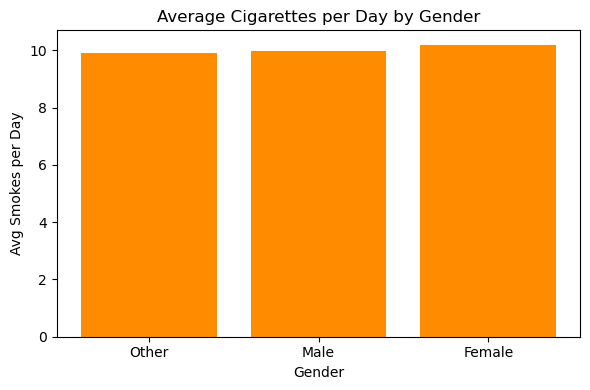

In [52]:
gender_smoke = df.groupby('gender')['smokes_per_day'].mean().sort_values()

plt.figure(figsize=(6, 4))
plt.bar(gender_smoke.index, gender_smoke.values, color='darkorange')
plt.title('Average Cigarettes per Day by Gender')
plt.ylabel('Avg Smokes per Day')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

/var/folders/0y/mr96fsm522d93sj5qzr85yr80000gn/T/ipykernel_92126/2026397004.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edu_smoking_age = df.groupby('education_level')['age_started_smoking'].mean().sort_values()


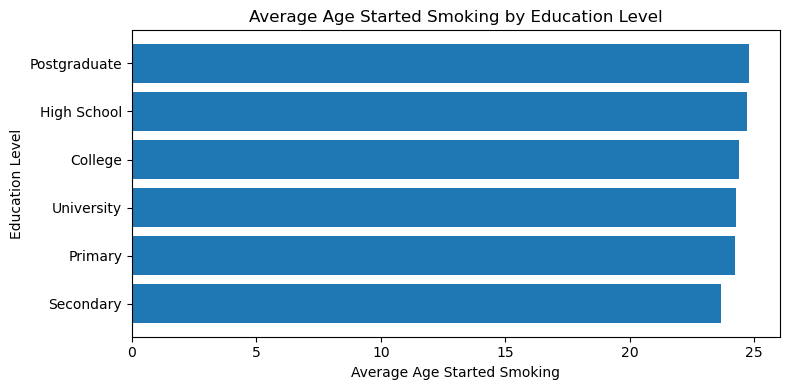

In [53]:
plt.figure(figsize=(8, 4))
edu_smoking_age = df.groupby('education_level')['age_started_smoking'].mean().sort_values()
plt.barh(edu_smoking_age.index, edu_smoking_age.values)
plt.title('Average Age Started Smoking by Education Level')
plt.xlabel('Average Age Started Smoking')
plt.ylabel('Education Level')
plt.tight_layout()
plt.show()

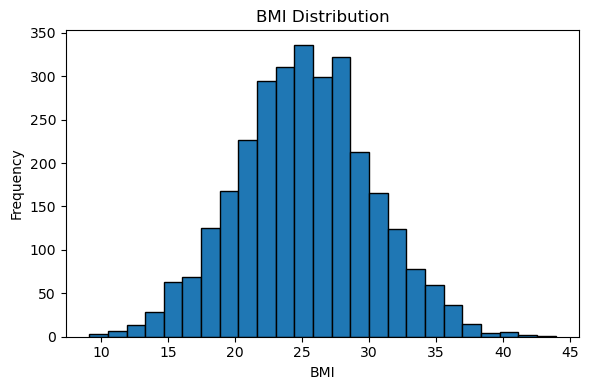

In [54]:
plt.figure(figsize=(6, 4))
plt.hist(df['bmi'], bins=25, edgecolor='black')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

/var/folders/0y/mr96fsm522d93sj5qzr85yr80000gn/T/ipykernel_92126/3185320234.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sleep = df.groupby('age_group')['sleep_hours'].mean()


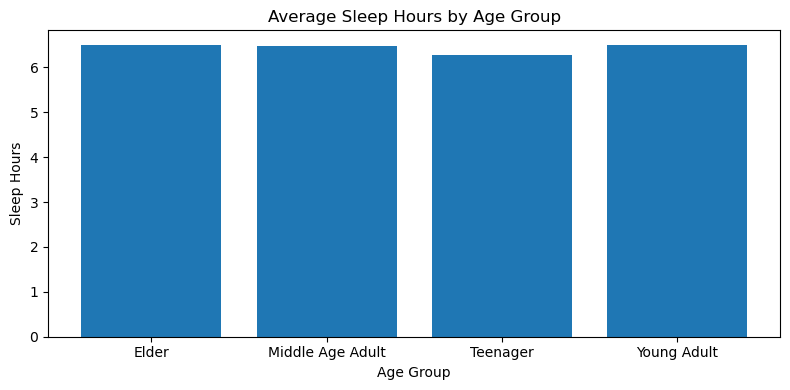

In [55]:
plt.figure(figsize=(8, 4))
age_sleep = df.groupby('age_group')['sleep_hours'].mean()
plt.bar(age_sleep.index, age_sleep.values)
plt.title('Average Sleep Hours by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Sleep Hours')
plt.tight_layout()
plt.show()

/var/folders/0y/mr96fsm522d93sj5qzr85yr80000gn/T/ipykernel_92126/1822695773.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  therapy_quit_smoke = df.groupby('therapy_history')['attempts_to_quit_smoking'].mean().sort_values()


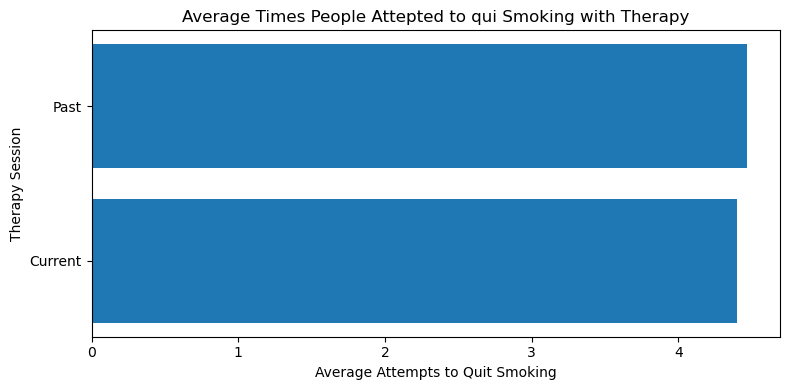

In [56]:
plt.figure(figsize=(8, 4))
therapy_quit_smoke = df.groupby('therapy_history')['attempts_to_quit_smoking'].mean().sort_values()
plt.barh(therapy_quit_smoke.index, therapy_quit_smoke.values)
plt.title('Average Times People Attepted to qui Smoking with Therapy')
plt.xlabel('Average Attempts to Quit Smoking')
plt.ylabel('Therapy Session')
plt.tight_layout()
plt.show()

/var/folders/0y/mr96fsm522d93sj5qzr85yr80000gn/T/ipykernel_92126/2174384277.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bmi_sleep = df.groupby('age_group')[['sleep_hours', 'bmi']].mean()


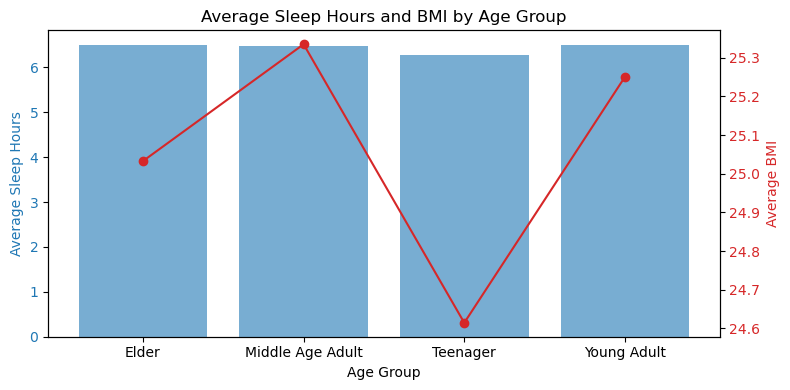

In [57]:
age_bmi_sleep = df.groupby('age_group')[['sleep_hours', 'bmi']].mean()

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.set_title('Average Sleep Hours and BMI by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Sleep Hours', color='tab:blue')
ax1.bar(age_bmi_sleep.index, age_bmi_sleep['sleep_hours'], alpha=0.6, label='Sleep Hours')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average BMI', color='tab:red')
ax2.plot(age_bmi_sleep.index, age_bmi_sleep['bmi'], color='tab:red', marker='o', label='BMI')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

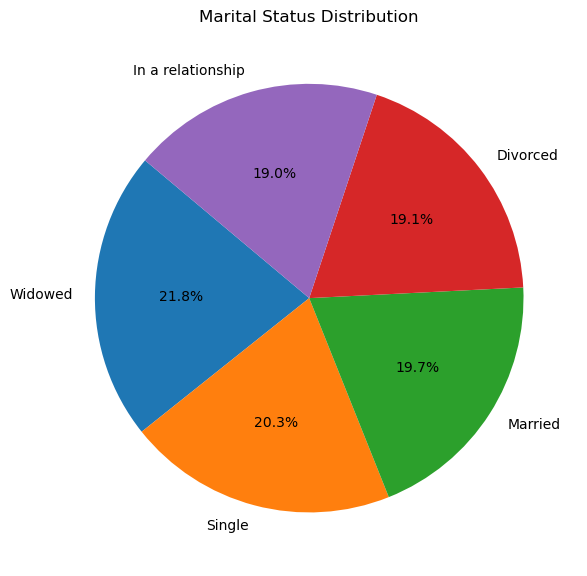

In [58]:
marital_counts = df['marital_status'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(marital_counts, labels=marital_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Marital Status Distribution')
plt.tight_layout()
plt.show()

In [59]:
# Save versioned CSVs under root/data
ensure_dir(P["interim_dir"])
ensure_dir(P["processed_dir"])

stem = "clean"  # adjust as needed
interim_path = to_interim(df, CFG, stem=stem, index=True)
processed_path = to_processed(df, CFG, stem=f"{stem}_features_v1", index=True)

print("interim ->", interim_path)
print("processed ->", processed_path)

interim -> /Users/christianfullerton/Desktop/Coding Workspace/Python Workspace/Full Projects/Cigarette-and-Drinking-Data/data/interim/20250903-184753_clean.csv
processed -> /Users/christianfullerton/Desktop/Coding Workspace/Python Workspace/Full Projects/Cigarette-and-Drinking-Data/data/processed/20250903-184753_clean_features_v1.csv
